In [1]:
import os
import sys
import time
import random
import pandas as pd
from pathlib import Path
import numpy as np
import torch

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from side_info_decoding.utils import (
    set_seed, 
    load_data_from_pids, 
    sliding_window_over_trials
)
from side_info_decoding.reduced_rank import (
    Full_Rank_Model, 
    train_single_task, 
    model_eval
)

seed = 666
set_seed(seed)

In [2]:
%matplotlib inline
plt.rc("figure", dpi=100)
SMALL_SIZE = 10
BIGGER_SIZE = 15
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=2)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=2)
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.size'] = 10

In [3]:
pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    # "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    # "523f8301-4f56-4faf-ab33-a9ff11331118",
    # "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    # '0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a',
    # '143dd7cf-6a47-47a1-906d-927ad7fe9117',
    # '16799c7a-e395-435d-a4c4-a678007e1550',
    # '1a60a6e1-da99-4d4e-a734-39b1d4544fad',
    # '1e176f17-d00f-49bb-87ff-26d237b525f1',
    # '31f3e083-a324-4b88-b0a4-7788ec37b191'
]

In [4]:
X_dict, Y_dict = load_data_from_pids(
    pids,
    brain_region="lp",
    behavior="choice",
    data_type="all_ks",
    n_t_bins = 30
)

pulling data from ibl database ..
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
number of trials found: 265 (active: 265)
prior for this session is not found.
found 265 trials from 17.56 to 2310.24 sec.
found 131 Kilosort units in region lp


Compute spike count: 100%|██████████████████| 265/265 [00:00<00:00, 1494.14it/s]


In [6]:
# an example of model training for 1 session

start_time = time.time()

example_pid = pids[0]
print(f"trainning full rank model on session {example_pid[:8]} ..")

R = 2 # rank
d = 0 # half window size
n_epochs = 7000

# prepare data
X, Y = X_dict[example_pid], Y_dict[example_pid]
K, C, T = X.shape
X = sliding_window_over_trials(X, half_window_size=d)
Y = sliding_window_over_trials(Y, half_window_size=d)
X, Y = torch.tensor(X), torch.tensor(Y)
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=seed)

frm = Full_Rank_Model(
    n_units=C, 
    n_t_bins=T, 
    half_window_size=d
)

# training
frm, train_losses = train_single_task(
    model=frm,
    train_dataset=(train_X, train_Y),
    test_dataset=(test_X, test_Y),
    loss_function=torch.nn.BCELoss(),
    learning_rate=1e-3,
    weight_decay=1e-1,
    n_epochs=5000,
)

# eval
test_Beta, test_metrics = model_eval(
    frm, 
    train_dataset=(train_X, train_Y),
    test_dataset=(test_X, test_Y),
    behavior="choice"
)

end_time = time.time()
print(f"time spent: {end_time - start_time: .3f} seconds")

trainning full rank model on session dab512bd ..
Epoch [500/5000], Loss: 12.531544390487324
Epoch [1000/5000], Loss: 6.900163768205322
Epoch [1500/5000], Loss: 2.2522576255881863
Epoch [2000/5000], Loss: 0.18402777522440222
Epoch [2500/5000], Loss: 0.02169217528396134
Epoch [3000/5000], Loss: 0.017267468422762475
Epoch [3500/5000], Loss: 0.015549602657157206
Epoch [4000/5000], Loss: 0.015103794446027823
Epoch [4500/5000], Loss: 0.015119467505744694
Epoch [5000/5000], Loss: 0.015204933380664292
train accuracy: 1.000 auc: 0.811
test accuracy: 0.811 auc: 0.877
time spent:  7.558 seconds


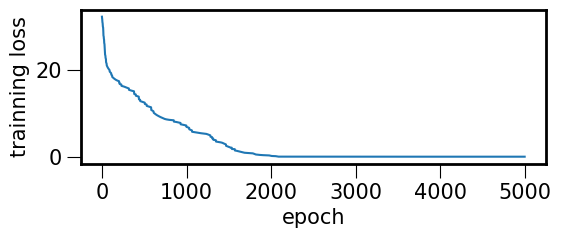

In [7]:
plt.figure(figsize=(6,2))
plt.plot(train_losses)
plt.xlabel("epoch")
plt.ylabel("trainning loss")
plt.show()

In [11]:
# example of performing 5-fold CV on all sessions

start_time = time.time()

R = 2 # rank
d = 0 # half window size
n_epochs = 5000

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

Betas, metrics = {}, {}
for pid in pids:
    
    print(f"start cross validation on session {pid[:8]} ..")
    X, Y = X_dict[pid], Y_dict[pid]
    K, C, T = X.shape
    X = sliding_window_over_trials(X, half_window_size=d)
    Y = sliding_window_over_trials(Y, half_window_size=d)
    X, Y = torch.tensor(X), torch.tensor(Y)
    
    Beta_per_fold, metrics_per_fold = [], []
    for fold_idx, (train, test) in enumerate(skf.split(X, Y)):
        
        print(f"start training on fold {fold_idx+1} ..")
        train_X, test_X = X[train], X[test]
        train_Y, test_Y = Y[train], Y[test]

        frm = Full_Rank_Model(
            n_units=C, 
            n_t_bins=T, 
            half_window_size=d
        )

        # training
        frm, train_losses = train_single_task(
            model=frm,
            train_dataset=(train_X, train_Y),
            test_dataset=(test_X, test_Y),
            loss_function=torch.nn.BCELoss(),
            learning_rate=1e-3,
            weight_decay=1e-1,
            n_epochs=n_epochs,
        )

        # eval
        test_Beta, test_metrics = model_eval(
            frm, 
            train_dataset=(train_X, train_Y),
            test_dataset=(test_X, test_Y),
            behavior="choice"
        )
        Beta_per_fold.append(test_Beta)
        metrics_per_fold.append(test_metrics)
        
    Betas.update({pid: Beta_per_fold})
    metrics.update({pid: metrics_per_fold})

end_time = time.time()
print(f"time spent: {end_time - start_time: .3f} seconds")

start cross validation on session dab512bd ..
start training on fold 1 ..
Epoch [500/5000], Loss: 13.346467845920914
Epoch [1000/5000], Loss: 7.242758221680741
Epoch [1500/5000], Loss: 2.331088002105015
Epoch [2000/5000], Loss: 0.1916168091668828
Epoch [2500/5000], Loss: 0.02553362428058477
Epoch [3000/5000], Loss: 0.02030878561666069
Epoch [3500/5000], Loss: 0.017756577756090183
Epoch [4000/5000], Loss: 0.016698681695584864
Epoch [4500/5000], Loss: 0.016298118594069128
Epoch [5000/5000], Loss: 0.016169404500819398
train accuracy: 1.000 auc: 0.906
test accuracy: 0.906 auc: 0.929
start training on fold 2 ..
Epoch [500/5000], Loss: 9.41755199340578
Epoch [1000/5000], Loss: 2.2152549816079965
Epoch [1500/5000], Loss: 0.21436881508419603
Epoch [2000/5000], Loss: 0.027401001589959482
Epoch [2500/5000], Loss: 0.02038525585752704
Epoch [3000/5000], Loss: 0.017218308625565976
Epoch [3500/5000], Loss: 0.015699410196549638
Epoch [4000/5000], Loss: 0.01513744682125763
Epoch [4500/5000], Loss: 0.0

In [12]:
metrics_dict = {}
for pid in pids:
    metrics_dict.update({pid: np.mean(metrics[pid], 0)})
metrics_df = pd.DataFrame(metrics_dict).T
metrics_df.columns = ["accuracy", "auc"]
metrics_df

,accuracy,auc
dab512bd-a02d-4c1f-8dbc-9155a163efc0,0.85283,0.917289


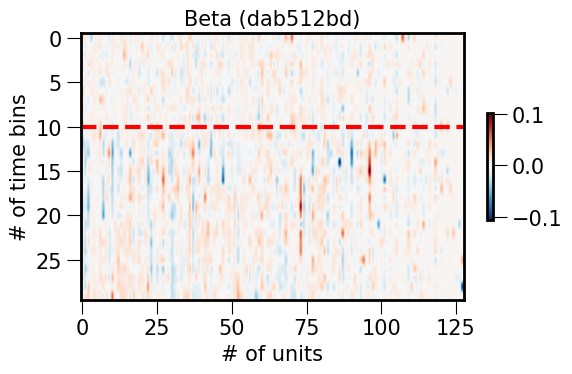

In [21]:
Betas_plot = []
for pid in pids:
    # average Beta across trials
    Betas_plot.append(np.array(Betas[pid]).mean(0).squeeze())
beta_min, beta_max = np.min(np.concatenate(Betas_plot)), np.max(np.concatenate(Betas_plot))
    
for pid_idx, pid in enumerate(pids):
    fig, ax = plt.subplots(1,1, figsize=(6, 4))
    heatmap = ax.imshow(Betas_plot[pid_idx].T, aspect="auto", cmap="RdBu_r", vmin=beta_min, vmax=beta_max)
    ax.axhline(y=10, c="red", linestyle="--", linewidth=3)
    cbar = fig.colorbar(heatmap, ax=ax, shrink=0.4)
    ax.set_ylabel("# of time bins")
    ax.set_xlabel("# of units")
    ax.set_title(f"Beta ({pid[:8]})")
    plt.tight_layout()